In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.cm import jet
%matplotlib inline

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [3]:
from background import NodeAndTimeAndMarkBackground, UniformTimeBackground, GaussianBackground, TimeAndMarkBackground
from clusters import NodeAndTimeAndMarkCluster, ExponentialTimeCluster, GaussianCluster, DefaultClusterFactory, TimeAndMarkCluster
from models import DirichletProcessMixtureModel, NeymanScottModel
from util import permute_to_match, onehot, compute_state_overlap

In [4]:
npr.seed(0)

In [5]:
# Make a Neyman-Scott model with gaussian marks
T = 100           # time window
M = 1             # number of nodes
data_dim = 2      # dimensionality of marks (e.g. vocab size in multinomial model)
lmbda0 = 100      # background rate of events (across all nodes)
tau = 5           # time constant of exponential impulse responses
mu = 20           # rate of latent events
alpha = 1         # shape of gamma prior on latent event weights
beta = alpha/20       # rate of gamma prior on latent event weights

# specify hyperparameters of cluster marks
niw_hypers = dict(mu0=np.zeros(data_dim),
                  lmbda=0.1,
                  Psi=(data_dim + 1 - 1) * np.eye(data_dim),
                  nu=data_dim+1)

In [6]:
bkgd_class = NodeAndTimeAndMarkBackground
bkgd_hypers = dict(
    num_nodes=M,
    node_distribution=np.ones(M) / M,
    time_class=UniformTimeBackground,
    time_kwargs=dict(T=T),
    mark_class=GaussianBackground,
    mark_kwargs=dict(data_dim=data_dim),
    )

# bkgd_class = GaussianBackground
# bkgd_hypers = dict(data_dim=data_dim)

cluster_class = NodeAndTimeAndMarkCluster
cluster_hypers = dict(
    num_nodes=M,
    node_concentration=0.5,
    time_class=ExponentialTimeCluster,
    time_kwargs=dict(T=T, tau=tau),
    mark_class=GaussianCluster,
    mark_kwargs=niw_hypers,
    )
# cluster_class = GaussianCluster
# cluster_hypers=niw_hypers

# Generate synthetic data and compare Gibbs to RJMCMC

In [7]:
true_model = NeymanScottModel(mu, alpha, beta, lmbda0, 
                              bkgd_class(**bkgd_hypers), 
                              DefaultClusterFactory(cluster_class, cluster_hypers))

# Sample from the model
sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
data, parents, clusters, weights = true_model.generate(**sample_kwargs)
times, marks = data[:, 0], data[:, 1:]

# Only keep the valid times
# valid = times < T
valid = np.ones_like(times, dtype=bool)
times = times[valid]
marks = marks[valid]
parents = parents[valid]

# Sort the data by time
perm = np.argsort(times)
times = times[perm]
marks = marks[perm]
parents = parents[perm]
data = np.column_stack((times, marks))
# data, parents, clusters, weights = true_model.generate()

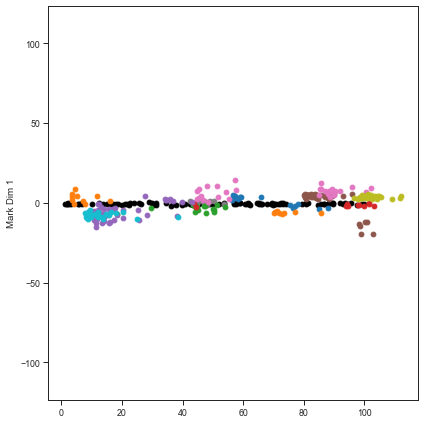

In [8]:
plt.figure(figsize=(6, 6))
ylim = 1.1 * abs(data).max()
for z in np.unique(parents):
    inds = np.where(parents == z)[0]
    plt.plot(data[inds, 1], data[inds, 2], 'o' if z >= 0 else 'ko')
#     plt.plot(data[inds], data[inds] + npr.randn(inds.size), 'o' if z >= 0 else 'ko')

plt.ylabel("Mark Dim 1")
plt.ylim(-ylim, ylim)

plt.tight_layout()

In [9]:
# Fit the correct model
num_samples = 100

# Run the Gibbs sampler with the true hyperparameters
print("true num clusters: ", len(clusters))
print("true lp: ", true_model.log_probability(data, clusters, weights))
gibbs_samples = true_model.gibbs_sample_posterior(data, num_samples=num_samples, init_method="background")

true num clusters:  17
true lp:  -1228.4005722017318
precomputing log_Vs



Gibbs sampling event parents


num clusters:  16  lp:  -1296.2154830435516
num clusters:  17  lp:  -1258.0503142922935
num clusters:  17  lp:  -1261.9560680666173
num clusters:  16  lp:  -1250.9260886985446
num clusters:  17  lp:  -1299.5435197587522
num clusters:  15  lp:  -1241.6458420833526
num clusters:  17  lp:  -1265.614908154641
num clusters:  17  lp:  -1237.83470294271
num clusters:  16  lp:  -1243.4740997106073
num clusters:  17  lp:  -1241.232619163799
num clusters:  16  lp:  -1246.7313675436717
num clusters:  18  lp:  -1246.725573380215
num clusters:  18  lp:  -1261.6342797314283
num clusters:  19  lp:  -1244.8917892005638
num clusters:  20  lp:  -1267.0742335270947
num clusters:  19  lp:  -1231.3265437665773
num clusters:  20  lp:  -1287.6214772682183
num clusters:  21  lp:  -1254.0436176756875
num clusters:  20  lp:  -1255.4783256638107
num clusters:  20  lp:  -1254.821365135318
num clusters:  20  lp:  -1287.8474531748134
num clusters:  20  lp:  -1277.9478675633802
num clusters:  18  lp:  -1227.57974321

In [10]:
# Fit the correct model with RJMCMC
num_samples = 100000

print("true num clusters: ", len(clusters))
print("true lp: ", true_model.log_probability(data, clusters, weights))

rjmcmc_samples = true_model.rjmcmc_sample_posterior(data, num_samples=num_samples, 
#                                                     init_method="given", clusters=clusters, weights=weights,
                                                    init_method="background")

true num clusters:  17
true lp:  -1228.4005722017318


num clusters:  0  lp:  -77407.74059805475
num clusters:  33  lp:  -2564.8424716510704
num clusters:  29  lp:  -2408.898891046581
num clusters:  32  lp:  -2337.764312153372
num clusters:  31  lp:  -2381.702332273009
num clusters:  24  lp:  -2429.0758029934113
num clusters:  26  lp:  -2298.293411911928
num clusters:  30  lp:  -2466.018766787044
num clusters:  28  lp:  -2323.6869724273424
num clusters:  30  lp:  -2692.4679226145618
num clusters:  34  lp:  -3046.8039469263117
num clusters:  38  lp:  -2485.5447559528693
num clusters:  32  lp:  -2577.7917535314527
num clusters:  28  lp:  -2396.8095848774874
num clusters:  28  lp:  -2362.799079532464
num clusters:  25  lp:  -2545.542503528297
num clusters:  26  lp:  -2451.614268952545
num clusters:  32  lp:  -3461.2438536783848
num clusters:  29  lp:  -2812.6324532958906
num clusters:  32  lp:  -2930.6452349899705
num clusters:  38  lp:  -2965.108863898085
num clusters:  36  lp:  -2715.3251420187808
num clusters:  31  lp:  -2720.2384718542708

num clusters:  32  lp:  -3373.5594041977965
num clusters:  35  lp:  -3147.6646739500266
num clusters:  36  lp:  -2597.8313631737515
num clusters:  28  lp:  -4016.3945162714535
num clusters:  27  lp:  -2879.6587961687223
num clusters:  26  lp:  -3306.042992128486
num clusters:  25  lp:  -3576.4565955782064
num clusters:  27  lp:  -2968.2229618098004
num clusters:  27  lp:  -2637.5600667484505
num clusters:  29  lp:  -2789.904127828002
num clusters:  32  lp:  -2618.1167796080804



In [11]:
# Fit the correct model with RJMCMC
num_samples = 1000

print("true num clusters: ", len(clusters))
print("true lp: ", true_model.log_probability(data, clusters, weights))

gibbsmh_samples = true_model.gibbs_mh_sample_posterior(
    data, num_samples=num_samples, 
    init_method="background")

true num clusters:  17
true lp:  -1228.4005722017318


num clusters:  0  lp:  -77407.74059805475
num clusters:  13  lp:  -22776.199675228538
num clusters:  17  lp:  -2634.7535635505765
num clusters:  17  lp:  -1477.832602161699
num clusters:  18  lp:  -1416.0863769845203
num clusters:  20  lp:  -1349.9029549235893
num clusters:  19  lp:  -1247.3140335217636
num clusters:  18  lp:  -1263.835880726077
num clusters:  18  lp:  -1227.6253874182228
num clusters:  16  lp:  -1225.4658971444032
num clusters:  16  lp:  -1250.6716737652273
num clusters:  16  lp:  -1220.4917402046583
num clusters:  15  lp:  -1239.8833763331972
num clusters:  16  lp:  -1203.5129788342456
num clusters:  17  lp:  -1231.732224420076
num clusters:  20  lp:  -1217.4017744327052
num clusters:  17  lp:  -1271.9504163631068
num clusters:  17  lp:  -1185.0761356188495
num clusters:  16  lp:  -1228.779159326205
num clusters:  16  lp:  -1256.050415271713
num clusters:  19  lp:  -1226.8237265741454
num clusters:  19  lp:  -1271.8632411773042
num clusters:  17  lp:  -1256.512121237

KeyboardInterrupt: 

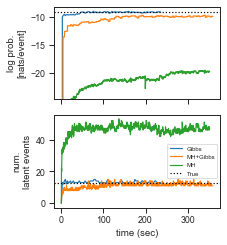

In [38]:
# Get the run time from the progress bars above
gibbs_time = 3 * 60 + 56
rjmcmc_time = 5 * 60 + 52
gibbsmh_time = 6 * 60 + 0

plt.figure(figsize=(3.25, 3.5))

plt.subplot(211)

# Plot the log joint probability
plt.plot(np.linspace(0, gibbs_time, len(gibbs_samples)),
         np.array([s["log_prob"] for s in gibbs_samples]) / len(data),
         label="Gibbs")
plt.plot(np.linspace(0, gibbsmh_time, len(gibbsmh_samples)),
         np.array([s["log_prob"] for s in gibbsmh_samples]) / len(data),
         label="MH+Gibbs")
plt.plot(np.linspace(0, rjmcmc_time, len(rjmcmc_samples))[::100],
         np.array([s["log_prob"] for s in rjmcmc_samples])[::100] / len(data),
         label="RJ-MCMC")

xl = plt.xlim()
true_lp = true_model.log_probability(data, clusters, weights)
plt.plot(xl, true_lp / len(data) * np.ones(2), ':k', label="True")
plt.xticks([0, 100, 200, 300], [])
plt.xlim(xl)

# plt.xlabel("time (sec)")
plt.ylabel("log prob.\n[nats/event]")
plt.ylim(-9000 / len(data), -3000 / len(data))
# plt.legend(loc="center right", fontsize=6)

# Plot number of clusters
plt.subplot(212)
plt.plot(np.linspace(0, gibbs_time, len(gibbs_samples)),
         np.array([s["num_clusters"] for s in gibbs_samples]),
        label="Gibbs")
plt.plot(np.linspace(0, gibbsmh_time, len(gibbsmh_samples)),
         np.array([s["num_clusters"] for s in gibbsmh_samples]),
        label="MH+Gibbs")
plt.plot(np.linspace(0, rjmcmc_time, len(rjmcmc_samples))[::100],
         np.array([s["num_clusters"] for s in rjmcmc_samples])[::100],
        label="MH")

# Plot the true likelihood
# xl = plt.xlim()
plt.plot(xl, len(clusters) * np.ones(2), ':k', label="True")
plt.xlim(xl)

plt.xlabel("time (sec)")
plt.ylabel("num.\nlatent events")
plt.legend(loc="center right", fontsize=6)

plt.tight_layout()

plt.savefig("synth3.pdf")

# Debug

In [16]:
# k = int(mu)
# k_smpls = [k]
# n_smpls = 20000
# for i in range(n_smpls):
#     move = npr.rand() < 0.5
#     if move == 1:
#         p_acc = mu / (k + 1)
#         if npr.rand() < p_acc:
#             k += 1
            
#     else:
#         # remove
#         p_acc = k / mu
#         if npr.rand() < p_acc:
#             k -= 1
            
#     k_smpls.append(k)
    
# plt.figure()
# plt.plot(k_smpls)
# plt.plot(mu * np.ones(n_smpls), '--')

# from scipy.stats import poisson
# plt.figure()
# plt.hist(k_smpls, density=True)
# plt.plot(np.arange(2 * mu), poisson.pmf(np.arange(2 * mu), mu))

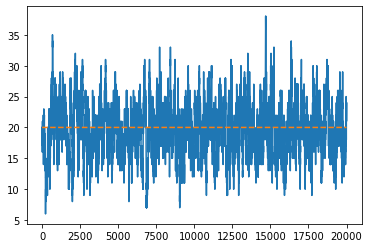

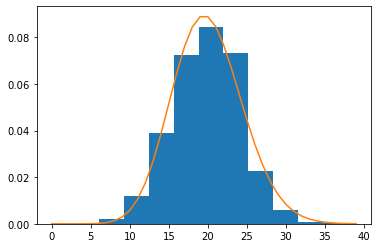

In [17]:
# k = int(mu)
# k_smpls = [k]
# n_smpls = 20000
# for i in range(n_smpls):
#     move = npr.rand() < 0.5
#     if move == 1:
#         p_acc = mu / (k + 1)
#         if npr.rand() < p_acc:
#             k += 1
            
#     else:
#         # remove
#         p_acc = k / mu
#         if npr.rand() < p_acc:
#             k -= 1
            
#     k_smpls.append(k)
    
# plt.figure()
# plt.plot(k_smpls)
# plt.plot(mu * np.ones(n_smpls), '--')

# from scipy.stats import poisson
# plt.figure()
# plt.hist(k_smpls, density=True)
# plt.plot(np.arange(2 * mu), poisson.pmf(np.arange(2 * mu), mu))